In [226]:
%reload_ext autoreload
%autoreload 2

from scipy import stats
import numpy as np
import nelpy as nel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ripple_heterogeneity.assembly.assembly_reactivation import AssemblyReact
from ripple_heterogeneity.utils import functions, loading, batch_analysis
from ad_ied.replay import reactivation
from neuro_py.plotting.events import plot_peth
import os
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'D:\github\ad_ied\results'

In [ ]:
df = pd.read_csv(r"D:\github\ad_ied\data\sessions.csv")
df = df.query("~basepath.str.contains('Naz1')")
df

In [ ]:
np.arange(-2,2,0.02)

In [ ]:
save_path = r"D:\github\ad_ied\results\reactivation_v2"
batch_analysis.run(
    df,
    save_path,
    reactivation.run,
    parallel=False,
    verbose=True,
    # z_mat_dt=0.02,
    # peth_window=2
)
results, peth = reactivation.load_results(save_path)

In [64]:
save_path = r"D:\github\ad_ied\results\reactivation_v2"

results_df, peth = reactivation.load_results(save_path)

peth_zscore = (peth - peth.mean(axis=0)) / peth.std(axis=0)

results_df

,response,assembly_n,epoch,event,n_cells,basepath
0,0.047502,0,pre,ied,37,X:\AD_sessions\AZ10\AZ10_210317_sess2
1,0.009256,1,pre,ied,37,X:\AD_sessions\AZ10\AZ10_210317_sess2
2,-0.025448,2,pre,ied,37,X:\AD_sessions\AZ10\AZ10_210317_sess2
3,0.164863,3,pre,ied,37,X:\AD_sessions\AZ10\AZ10_210317_sess2
4,-0.015473,4,pre,ied,37,X:\AD_sessions\AZ10\AZ10_210317_sess2
...,...,...,...,...,...,...
943,1.159582,3,post,ripples_post_ied,35,X:\AD_sessions\AZ18\AZ18_221129_sess10
944,-0.023725,4,post,ripples_post_ied,35,X:\AD_sessions\AZ18\AZ18_221129_sess10
945,4.954879,5,post,ripples_post_ied,35,X:\AD_sessions\AZ18\AZ18_221129_sess10
946,0.501553,6,post,ripples_post_ied,35,X:\AD_sessions\AZ18\AZ18_221129_sess10


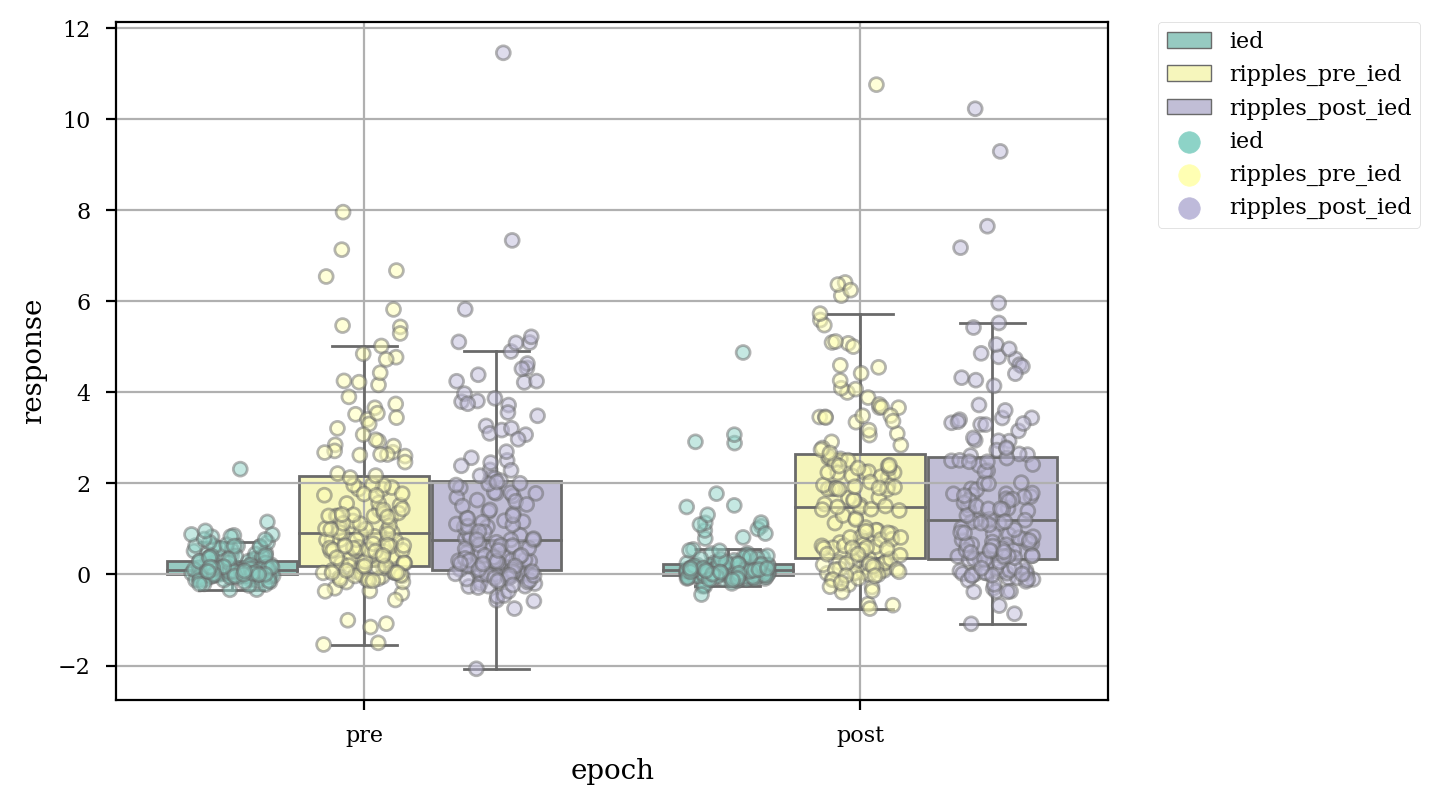

In [65]:
sns.boxplot(
    data=results_df,
    x="epoch",
    y="response",
    hue="event",
    palette="Set3",
    linewidth=1,
    fliersize=0,
)
sns.stripplot(
    data=results_df,
    x="epoch",
    y="response",
    hue="event",
    palette="Set3",
    linewidth=1,
    dodge=True,
    alpha=0.5,
    jitter=0.25,
)
plt.grid()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

(-10.0, 20.0)

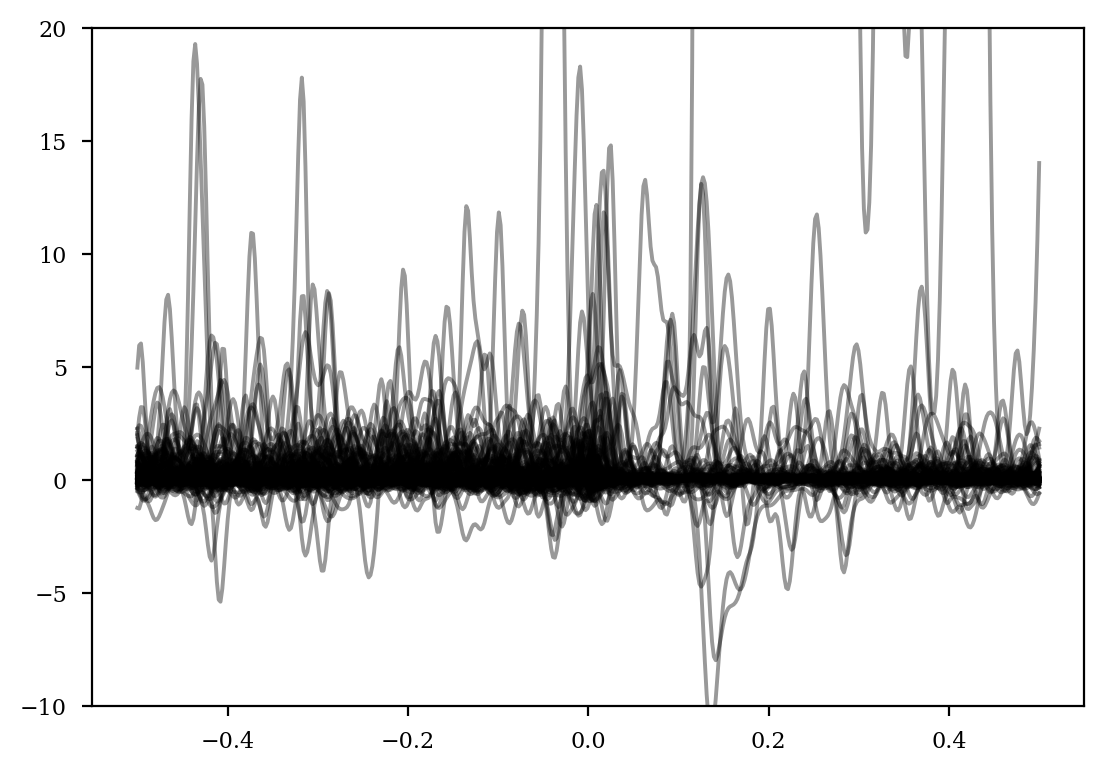

In [68]:
peth.iloc[:,(results_df.event.values=="ied") & (results_df.epoch.values=="post")].plot(legend=False,alpha=.4,color="k")
plt.ylim(-10,20)

Text(0.5, 1.0, 'Post-IED Assembly Reactivation')

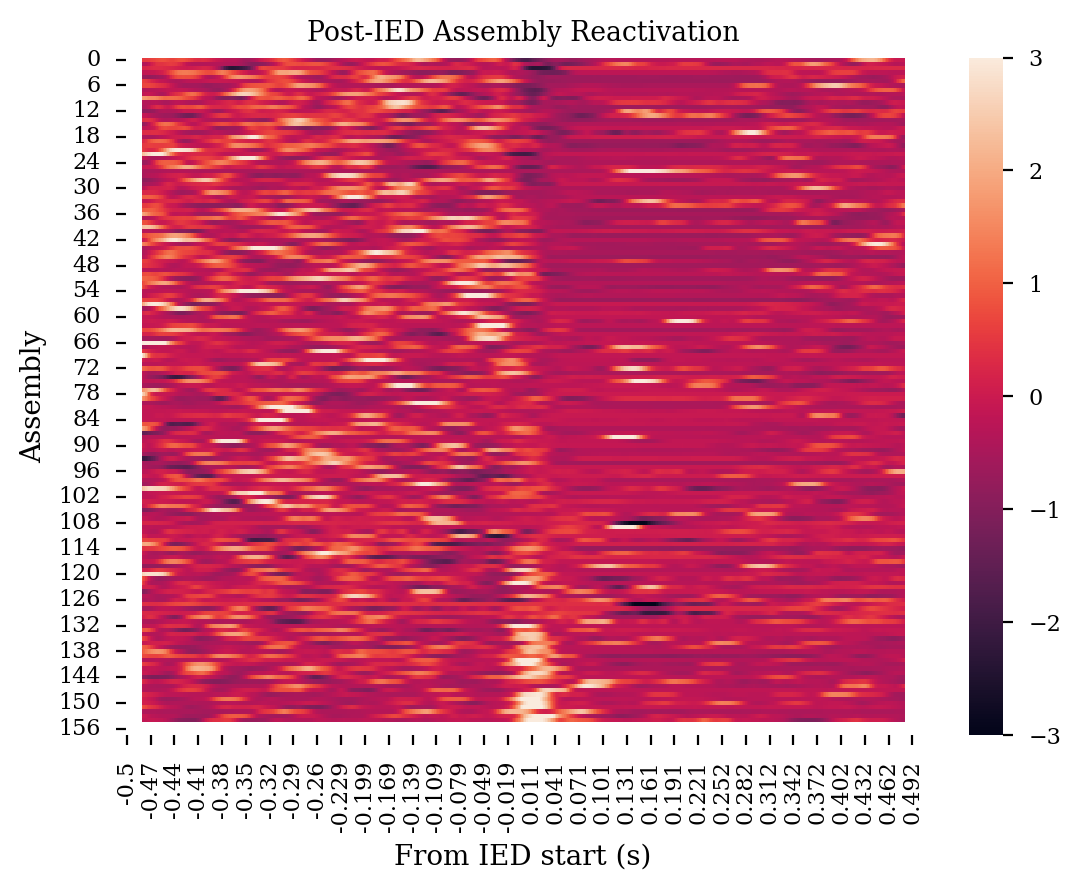

In [150]:
ied_post_idx = (results_df.event.values=="ied") & (results_df.epoch.values=="post")
peth_ied_zscore = peth_zscore.iloc[:,ied_post_idx].copy()
peth_ied_zscore.index = peth_ied_zscore.index.values.round(3)

# smooth each column of peth_ied_zscore
peth_ied_zscore = peth_ied_zscore.apply(lambda x: x.rolling(20,center=True).mean())

idx = np.argsort(peth_ied_zscore.iloc[(peth_ied_zscore.index > 0) & (peth_ied_zscore.index < 0.1),:].mean().values)
peth_ied_zscore = peth_ied_zscore.iloc[:,idx]

# reset column names
peth_ied_zscore.columns = np.arange(peth_ied_zscore.shape[1])

ax = sns.heatmap(peth_ied_zscore.T,vmin=-3,vmax=3)
# ax.set_xticks(np.linspace(0,len(peth_ied_zscore.index.values),5),np.linspace(-.5,.5,5))
plt.xlabel("From IED start (s)")
plt.ylabel("Assembly")
plt.title("Post-IED Assembly Reactivation")

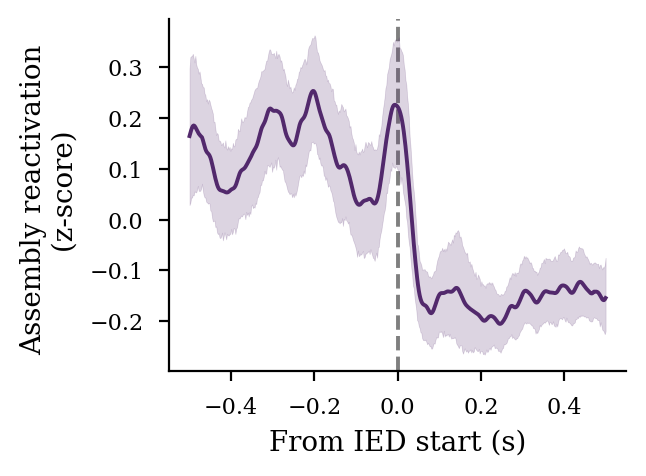

In [165]:
# group_colors = {"Pre": "#b3a5c4", "Post": "#52296c"}
group_colors = {"Pre": "blue", "Post": "red"}

fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=.5, subplots=(1.25, 1)), edgecolor=None
)

ied_post_idx = (results_df.event.values=="ied") & (results_df.epoch.values=="post")
peth_ied_zscore = peth_zscore.iloc[:,ied_post_idx].copy()

peth_ied_zscore = peth_ied_zscore.apply(lambda x: x.rolling(30,center=True, min_periods=1).mean())

plot_peth(peth_ied_zscore,color="#52296c",ax=ax)
ax.set_ylabel("Assembly reactivation \n (z-score)")
ax.set_xlabel("From IED start (s)")
ax.axvline(0, color="black", linestyle="--",zorder=-1000,alpha=.5)

plt.savefig(
    os.path.join(fig_save_path, "assembly_react_ied_peth.svg"),
    dpi=300,
    bbox_inches="tight",
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre vs. Post: t-test paired samples, P_val:1.285e-05 t=4.509e+00


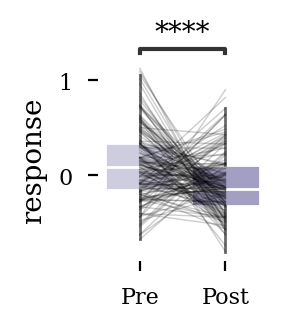

In [233]:
peth_response_df_pre = pd.DataFrame()
peth_response_df_pre["response"] = peth_ied_zscore.iloc[(peth_ied_zscore.index > -0.2) & (peth_ied_zscore.index < 0),:].mean()
peth_response_df_pre["ID"] = peth_ied_zscore.columns.values
peth_response_df_pre["label"] = "Pre"

peth_response_df_post = pd.DataFrame()
peth_response_df_post["response"] = peth_ied_zscore.iloc[(peth_ied_zscore.index > 0) & (peth_ied_zscore.index < 0.2),:].mean()
peth_response_df_post["ID"] = peth_ied_zscore.columns.values
peth_response_df_post["label"] = "Post"

peth_response_df = pd.concat([peth_response_df_pre,peth_response_df_post],ignore_index=True)
peth_response_df

group_colors = {"Pre": "#ccc9e2", "Post": "#9e99c9"}

# fig, ax = plt.subplots(
#     figsize=functions.set_size("thesis", fraction=.12, subplots=(3, 1)), edgecolor=None
# )
fig, ax = plt.subplots(
    figsize=(1.096,1.310), edgecolor=None
)
sns.boxplot(
    data=peth_response_df,
    x="label",
    y="response",
    palette=group_colors,
    linewidth=1,
    fliersize=0,
    showfliers=False,
    medianprops=dict(color="white", alpha=1),
    capprops=dict(alpha=0),
    boxprops=dict(edgecolor="white"),
)
sns.lineplot(
    y="response",
    x="label",
    data=peth_response_df,
    units="ID",
    estimator=None,
    color="k",
    alpha=.2,
    linewidth=.5,
    legend=True,
    zorder = 1000,
)
# sns.stripplot(data=peth_response_df, x="label", y="response", color="k",jitter=True,s=3,alpha=.25)
plt.ylabel("response")
plt.xlabel("")
sns.despine(bottom=True, left=True)

box_pairs = [("Pre", "Post")]
annotator = Annotator(
    ax,
    box_pairs,
    data=peth_response_df,
    y="response",
    x="label",
)
annotator.configure(
    test="t-test_paired",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "assembly_react_ied_peth_boxplot.svg"),
    dpi=300,
    bbox_inches="tight",
)

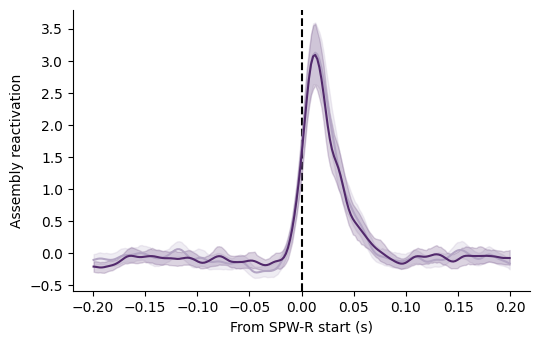

In [35]:
group_colors = {"Pre": "#b3a5c4", "Post": "#52296c"}
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=1, subplots=(1, 1)), edgecolor=None
)
time_idx = (peth_zscore.index>-.2) & (peth_zscore.index<.2)
plot_peth(peth_zscore.iloc[time_idx,(results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="post")],color=group_colors["Pre"],ax=ax)
plot_peth(peth_zscore.iloc[time_idx,(results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="post")],color=group_colors["Post"],ax=ax)
ax.set_ylabel("Assembly reactivation")
ax.set_xlabel("From SPW-R start (s)")
ax.axvline(0, color="black", linestyle="--",zorder=-100)

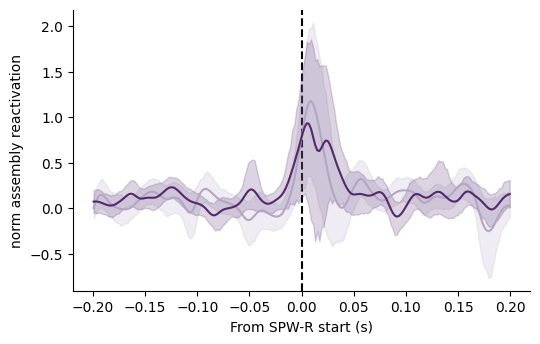

In [8]:
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=1, subplots=(1, 1)), edgecolor=None
)
pre_idx = (results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="pre")
post_idx = (results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="post")

normalized_peth_pre = pd.DataFrame(
    index=peth.index, columns=np.arange(sum(pre_idx)), data=peth.iloc[ :,post_idx].values - peth.iloc[:,pre_idx].values
)
pre_idx = (results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="pre")
post_idx = (results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="post")
normalized_peth_post = pd.DataFrame(
    index=peth.index, columns=np.arange(sum(pre_idx)), data=peth.iloc[ :,post_idx].values - peth.iloc[:,pre_idx].values
)

plot_peth(normalized_peth_pre.iloc[time_idx,:],color=group_colors["Pre"],ax=ax)
plot_peth(normalized_peth_post.iloc[time_idx,:],color=group_colors["Post"],ax=ax)

ax.set_ylabel("norm assembly reactivation")
ax.set_xlabel("From SPW-R start (s)")
ax.axvline(0, color="black", linestyle="--",zorder=-100)

<AxesSubplot: >

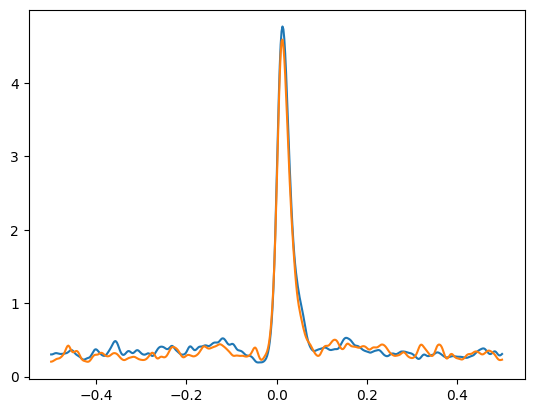

In [9]:
peth.iloc[:,(results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="post")].mean(axis=1).plot(legend=False)
peth.iloc[:,(results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="post")].mean(axis=1).plot(legend=False)


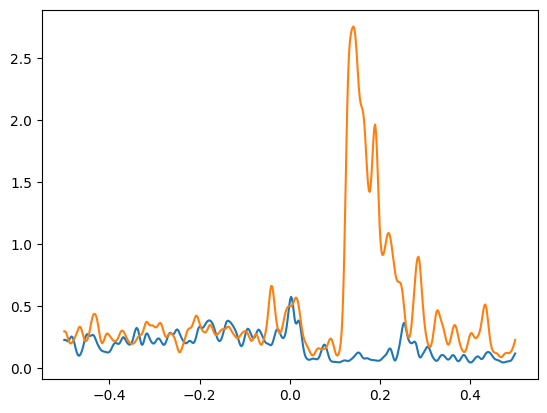

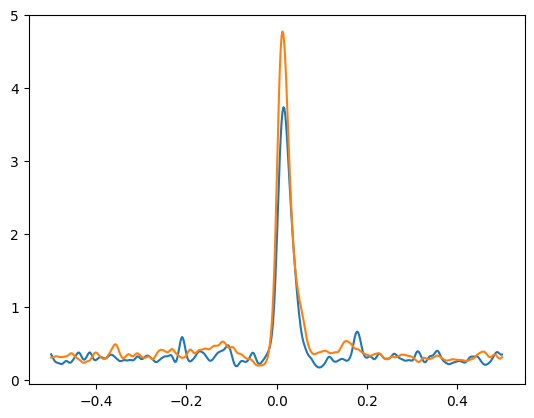

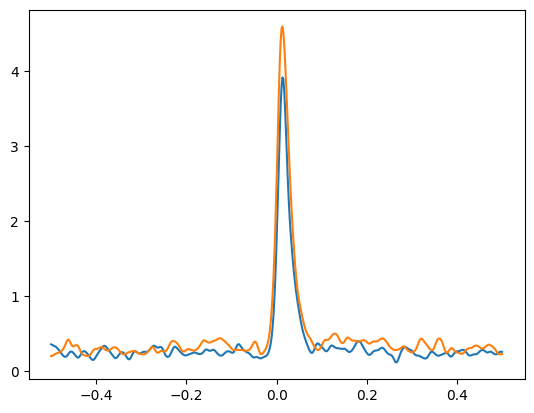

In [10]:
# peth.plot()

peth.iloc[:,(results_df.event.values=="ied") & (results_df.epoch.values=="pre")].mean(axis=1).plot(legend=False)
peth.iloc[:,(results_df.event.values=="ied") & (results_df.epoch.values=="post")].mean(axis=1).plot(legend=False)
plt.show()

peth.iloc[:,(results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="pre")].mean(axis=1).plot(legend=False)
peth.iloc[:,(results_df.event.values=="ripples_pre_ied") & (results_df.epoch.values=="post")].mean(axis=1).plot(legend=False)
plt.show()

peth.iloc[:,(results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="pre")].mean(axis=1).plot(legend=False)
peth.iloc[:,(results_df.event.values=="ripples_post_ied") & (results_df.epoch.values=="post")].mean(axis=1).plot(legend=False)
plt.show()
# peth.iloc[:,results_df.event.values=="ripples_pre_ied"].mean(axis=1).plot(legend=False)
# peth.iloc[:,results_df.event.values=="ripples_post_ied"].mean(axis=1).plot(legend=False)
